# Sales Tax Vs Income by zipcode

Hypothesis, do high sales tax zip codes correlate with low income zip codes? Let’s Find out. Below is the code and the dataset sources.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# https://catalog.data.gov/dataset/zip-code-data
# IRS data from 2016

df = pd.read_csv('16zpallagi.csv')

In [3]:
df.head(5)

,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,PREP,N2,...,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902
0,1,AL,0,1,815440,477700,105350,221200,440830,1296920,...,367320,330066,0,0,0,0,63420,51444,711580,1831661
1,1,AL,0,2,495830,211930,142340,128890,272440,996240,...,398050,984297,0,0,0,0,74090,110889,416090,1173463
2,1,AL,0,3,263390,83420,137870,36340,154880,584000,...,253180,1349246,0,0,0,0,64000,143060,195130,543284
3,1,AL,0,4,167190,29420,124060,10610,99700,421720,...,165830,1425430,0,0,0,0,45020,128920,117410,381329
4,1,AL,0,5,217440,20240,188080,4880,129410,601040,...,216720,3922449,390,155,60,19,82940,423629,126130,506526


In [4]:
# grabbing appropriate columns and renameing
gi_df = df[['STATE', 'zipcode', 'agi_stub', 'N1']]

In [5]:
gi_df = gi_df.rename(columns = {'STATE': 'state', 'zipcode': 'zipcode', 'agi_stub': 'agi_stub', 'N1': 'returns'})
gi_df.head(12)

,state,zipcode,agi_stub,returns
0,AL,0,1,815440
1,AL,0,2,495830
2,AL,0,3,263390
3,AL,0,4,167190
4,AL,0,5,217440
5,AL,0,6,57240
6,AL,35004,1,1510
7,AL,35004,2,1410
8,AL,35004,3,950
9,AL,35004,4,650


in each zip code there are 6 'agi_stub' income 'buckets' based on income levels. First step is to create a new gross income column. I used the max value for each. 

In [6]:
def gi(row):
    if row['agi_stub'] == 1:
        val = 25000
    elif row['agi_stub'] == 2:
        val = 50000
    elif row['agi_stub'] == 3:
        val = 75000
    elif row['agi_stub'] == 4:
        val = 100000
    elif row['agi_stub'] == 5:
        val = 200000
    elif row['agi_stub'] == 6:
        val = 200001     
    return val        

In [7]:
gi_df['gross_income'] = gi_df.apply(gi, axis=1)

In [8]:
gi_df.head(12)

,state,zipcode,agi_stub,returns,gross_income
0,AL,0,1,815440,25000
1,AL,0,2,495830,50000
2,AL,0,3,263390,75000
3,AL,0,4,167190,100000
4,AL,0,5,217440,200000
5,AL,0,6,57240,200001
6,AL,35004,1,1510,25000
7,AL,35004,2,1410,50000
8,AL,35004,3,950,75000
9,AL,35004,4,650,100000


need to use a weighted average to assign a 'rolled-up' gross income by zipcode.
http://pbpython.com/weighted-average.html


In [9]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [10]:
# testing the function
wavg(gi_df, "gross_income", "returns")

74788.141569520536

In [11]:
# new series to group by the zipcode
weighted_gross = gi_df.groupby(["state","zipcode"]).apply(wavg, "gross_income", "returns")

In [12]:
weighted_gross.head()

state  zipcode
AK     0          81123.677231
       99501      74302.979721
       99502      88799.034923
       99503      68637.564267
       99504      74569.883733
dtype: float64

In [13]:
# dataframe
a = pd.Series.to_frame(weighted_gross).reset_index()
a.head()

,state,zipcode,0
0,AK,0,81123.677231
1,AK,99501,74302.979721
2,AK,99502,88799.034923
3,AK,99503,68637.564267
4,AK,99504,74569.883733


In [14]:
# name columns and remove the 99999 and 00000 zipcodes

a.columns = ['state', 'zipcode', 'weighted_gross']
mask_zip1 = a['zipcode'] != 99999
mask_zip2 = a['zipcode'] != 00000
a = a[mask_zip1 & mask_zip2]

In [15]:
# final gross_income dataframe
a.head()

,state,zipcode,weighted_gross
1,AK,99501,74302.979721
2,AK,99502,88799.034923
3,AK,99503,68637.564267
4,AK,99504,74569.883733
5,AK,99505,54032.258065


In [16]:
# dataset with sales tax by zipcode
# https://www.avalara.com/taxrates/en/download-tax-tables.html

miz_df = pd.read_csv('sales_tax_rates_merged.csv')

In [17]:
miz_df.head()

,state,zipcode,TaxRegionName,TaxRegionCode,CombinedRate,StateRate,CountyRate,CityRate,SpecialRate
0,AK,99501,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0
1,AK,99502,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0
2,AK,99503,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0
3,AK,99504,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0
4,AK,99505,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0


In [18]:
miz_df.tail()

,state,zipcode,TaxRegionName,TaxRegionCode,CombinedRate,StateRate,CountyRate,CityRate,SpecialRate
40896,WY,83124,ROCK SPRINGS,MVLS,0.05,0.04,0.01,0.0,0.0
40897,WY,83126,LINCOLN COUNTY,BXYX,0.05,0.04,0.01,0.0,0.0
40898,WY,83127,STAR VALLEY RANCH,MVLY,0.05,0.04,0.01,0.0,0.0
40899,WY,83128,LINCOLN COUNTY,BXYX,0.05,0.04,0.01,0.0,0.0
40900,WY,83414,ALTA,NFUB,0.06,0.04,0.02,0.0,0.0


In [19]:
miz_df.isnull().sum()

state                0
zipcode              0
TaxRegionName        0
TaxRegionCode    23043
CombinedRate         1
StateRate            1
CountyRate           1
CityRate             1
SpecialRate          2
dtype: int64

In [20]:
# data looks good let's merge with gross_income
sales_income_df = miz_df.merge(a, on=['state', 'zipcode'], how='outer')

In [21]:
sales_income_df.head()

,state,zipcode,TaxRegionName,TaxRegionCode,CombinedRate,StateRate,CountyRate,CityRate,SpecialRate,weighted_gross
0,AK,99501,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0,74302.979721
1,AK,99502,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0,88799.034923
2,AK,99503,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0,68637.564267
3,AK,99504,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0,74569.883733
4,AK,99505,ALASKA STATE,AAAA,0.0,0.0,0.0,0.0,0.0,54032.258065


In [22]:
sales_income_df['weighted_gross'].corr(sales_income_df['CombinedRate'])

0.0038487148752592033

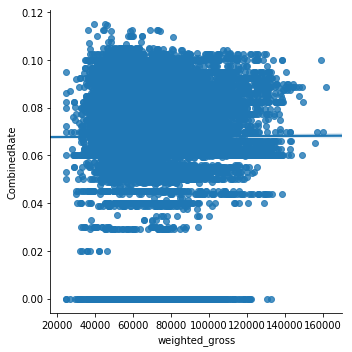

In [26]:
import seaborn as sns
c = sns.lmplot(x='weighted_gross', y='CombinedRate', data=sales_income_df)

so a slight negative correlation. The higher the median income the lower the sales tax or the higher the sales tax the lower the median income. This is slight and not highly correlated.

## Export to Visualize in Tableau
using Tableau to visualize by zipcode.

In [24]:
sales_income_df.to_csv('sales_income_df.csv')